## **Libraries**

In [1]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

## **Data**

In [2]:
# Load raw data
df_purchase = pd.read_csv(os.path.join("..", "data", "purchase_data.csv"))

In [3]:
# Load pickled objects in order to segment the purchase data
kmeans_pca = pickle.load(open(os.path.join("utils", "kmeans_pca.pickle"), "rb"))
pca = pickle.load(open(os.path.join("utils", "pca.pickle"), "rb"))
scaler = pickle.load(open(os.path.join("utils", "scaler.pickle"), "rb"))

In [4]:
# Standardization
features = df_purchase[["Sex", "Marital status", "Age", "Education", "Income", "Occupation", "Settlement"]]
df_segm_std = scaler.transform(features)

In [5]:
# Apply PCA on the purchase data to obtain three principal components for each row in the table
df_segm_pca = pca.transform(df_segm_std)

In [6]:
# Segment the purchase data into the four segments using the principal component analysis
pca_segments = kmeans_pca.predict(df_segm_pca)

In [7]:
# Create a copy to keep original data
df_predictors = df_purchase.copy()

In [8]:
# Add segment labels
df_predictors["Segment"] = pca_segments

In [9]:
# Create segment dummies
segment_dummies = pd.get_dummies(pca_segments, prefix = "Segment", prefix_sep = "_")

In [10]:
# Concatenate the two data frames
df_predictors = pd.concat([df_predictors, segment_dummies], axis = 1)

In [11]:
# Create a copy to keep original data
df_pca = df_predictors

## **Purchase Probability**

### **Model**

In [12]:
# Set the dependent variable to predict the purchase probability
Y = df_pca["Incidence"]

In [13]:
# The dependent variable is based on the the mean across the five prices
X = pd.DataFrame()
X["Mean_Price"] = (df_pca["Price_1"] +
                   df_pca["Price_2"] +
                   df_pca["Price_3"] +
                   df_pca["Price_4"] +
                   df_pca["Price_5"]) / 5

In [14]:
# Fit a logistic regression to estimate the probability of purchase
model_purchase = LogisticRegression(solver = "sag")
model_purchase.fit(X, Y)
model_purchase.coef_

array([[-2.34774073]])

### **Elasticity**

In [15]:
# Show the price range for the five different brands
df_pca[["Price_1", "Price_2", "Price_3", "Price_4", "Price_5"]].describe().round(3)

,Price_1,Price_2,Price_3,Price_4,Price_5
count,58693.000,58693.000,58693.000,58693.00,58693.000
mean,1.392,1.781,2.007,2.16,2.655
std,0.091,0.171,0.047,0.09,0.098
min,1.100,1.260,1.870,1.76,2.110
25%,1.340,1.580,1.970,2.12,2.630
50%,1.390,1.880,2.010,2.17,2.670
75%,1.470,1.890,2.060,2.24,2.700
max,1.590,1.900,2.140,2.26,2.800


In [16]:
# Introduce the price range for examination of purchase probability
price_range = np.arange(0.5, 3.5, 0.01)
price_range

array([0.5 , 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 ,
       0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71,
       0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82,
       0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93,
       0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  , 1.01, 1.02, 1.03, 1.04,
       1.05, 1.06, 1.07, 1.08, 1.09, 1.1 , 1.11, 1.12, 1.13, 1.14, 1.15,
       1.16, 1.17, 1.18, 1.19, 1.2 , 1.21, 1.22, 1.23, 1.24, 1.25, 1.26,
       1.27, 1.28, 1.29, 1.3 , 1.31, 1.32, 1.33, 1.34, 1.35, 1.36, 1.37,
       1.38, 1.39, 1.4 , 1.41, 1.42, 1.43, 1.44, 1.45, 1.46, 1.47, 1.48,
       1.49, 1.5 , 1.51, 1.52, 1.53, 1.54, 1.55, 1.56, 1.57, 1.58, 1.59,
       1.6 , 1.61, 1.62, 1.63, 1.64, 1.65, 1.66, 1.67, 1.68, 1.69, 1.7 ,
       1.71, 1.72, 1.73, 1.74, 1.75, 1.76, 1.77, 1.78, 1.79, 1.8 , 1.81,
       1.82, 1.83, 1.84, 1.85, 1.86, 1.87, 1.88, 1.89, 1.9 , 1.91, 1.92,
       1.93, 1.94, 1.95, 1.96, 1.97, 1.98, 1.99, 2.

In [17]:
# Create a new data frame based on the price range defined above
df_price = pd.DataFrame(price_range)
df_price.head()

,0
0,0.50
1,0.51
2,0.52
3,0.53
4,0.54


In [18]:
# Predict and extract the purchase probability for each point in our price range defined in the second column
Y_pr = model_purchase.predict_proba(df_price)
purchase_probability = Y_pr[:][:, 1]

In [19]:
# Compute the price elasticity using model coefficients
price_elasticity = model_purchase.coef_[:, 0] * price_range * (1 - purchase_probability)

In [20]:
# Create a data frame that contains all the prices elasticities calculated
df_elasticities = pd.DataFrame(price_range)
df_elasticities.head()

,0
0,0.50
1,0.51
2,0.52
3,0.53
4,0.54


In [21]:
# Add the price elasticities calculated before
df_elasticities = df_elasticities.rename(columns = {0: "Price_Point"})
df_elasticities["Price_Elasticity"] = price_elasticity
df_elasticities.head()

,Price_Point,Price_Elasticity
0,0.50,-0.096399
1,0.51,-0.100467
2,0.52,-0.104662
3,0.53,-0.108987
4,0.54,-0.113445


Text(0, 0.5, 'Elasticity')

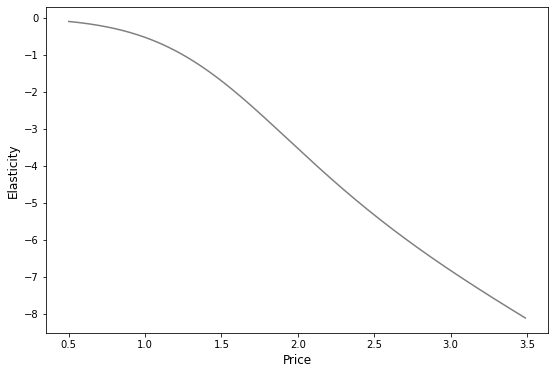

In [22]:
# Display the price elasticity of purchase probability of the average customer
plt.figure(figsize = (9, 6))
plt.plot(price_range, price_elasticity, color = "grey")
plt.xlabel("Price", fontsize = 12)
plt.ylabel("Elasticity", fontsize = 12)

### **By Segments**

In [23]:
# Segment 0 - Standard
df_segm_0 = df_pca[df_pca["Segment"] == 0]
Y = df_segm_0["Incidence"]

X = pd.DataFrame()
X["Mean_Price"] = (df_segm_0["Price_1"] + 
                   df_segm_0["Price_2"] + 
                   df_segm_0["Price_3"] + 
                   df_segm_0["Price_4"] + 
                   df_segm_0["Price_5"]) / 5

model_segm_0 = LogisticRegression(solver = "sag")
model_segm_0.fit(X, Y)

Y_segm_0 = model_segm_0.predict_proba(df_price)
pp_segm_0 = Y_segm_0[:][:, 1]                                           # Purchase Probability (PP)
pe_segm_0 = model_segm_0.coef_[:, 0] * price_range * (1 - pp_segm_0)    # Price Elasticity (PE)

df_elasticities["PE_Segment_0"] = pe_segm_0

In [24]:
# Segment 1 - Career-Focused
df_segm_1 = df_pca[df_pca["Segment"] == 1]
Y = df_segm_1["Incidence"]

X = pd.DataFrame()
X["Mean_Price"] = (df_segm_1["Price_1"] + 
                   df_segm_1["Price_2"] + 
                   df_segm_1["Price_3"] + 
                   df_segm_1["Price_4"] + 
                   df_segm_1["Price_5"]) / 5

model_segm_1 = LogisticRegression(solver = "sag")
model_segm_1.fit(X, Y)

Y_segm_1 = model_segm_1.predict_proba(df_price)
pp_segm_1 = Y_segm_1[:][:, 1]                                           # Purchase Probability (PP)
pe_segm_1 = model_segm_1.coef_[:, 0] * price_range * (1 - pp_segm_1)    # Price Elasticity (PE)

df_elasticities["PE_Segment_1"] = pe_segm_1

In [25]:
# Segment 2 - Fewer-Opportunities
df_segm_2 = df_pca[df_pca["Segment"] == 2]
Y = df_segm_2["Incidence"]

X = pd.DataFrame()
X["Mean_Price"] = (df_segm_2["Price_1"] + 
                   df_segm_2["Price_2"] + 
                   df_segm_2["Price_3"] + 
                   df_segm_2["Price_4"] + 
                   df_segm_2["Price_5"]) / 5

model_segm_2 = LogisticRegression(solver = "sag")
model_segm_2.fit(X, Y)

Y_segm_2 = model_segm_2.predict_proba(df_price)
pp_segm_2 = Y_segm_2[:][:, 1]                                           # Purchase Probability (PP)
pe_segm_2 = model_segm_2.coef_[:, 0] * price_range * (1 - pp_segm_2)    # Price Elasticity (PE)

df_elasticities["PE_Segment_2"] = pe_segm_2

In [26]:
# Segment 3 - Well-Off
df_segm_3 = df_pca[df_pca["Segment"] == 3]
Y = df_segm_3["Incidence"]

X = pd.DataFrame()
X["Mean_Price"] = (df_segm_3["Price_1"] + 
                   df_segm_3["Price_2"] + 
                   df_segm_3["Price_3"] + 
                   df_segm_3["Price_4"] + 
                   df_segm_3["Price_5"]) / 5

model_segm_3 = LogisticRegression(solver = "sag")
model_segm_3.fit(X, Y)

Y_segm_3 = model_segm_3.predict_proba(df_price)
pp_segm_3 = Y_segm_3[:][:, 1]                                           # Purchase Probability (PP)
pe_segm_3 = model_segm_3.coef_[:, 0] * price_range * (1 - pp_segm_3)    # Price Elasticity (PE)

df_elasticities["PE_Segment_3"] = pe_segm_3

### **Results**

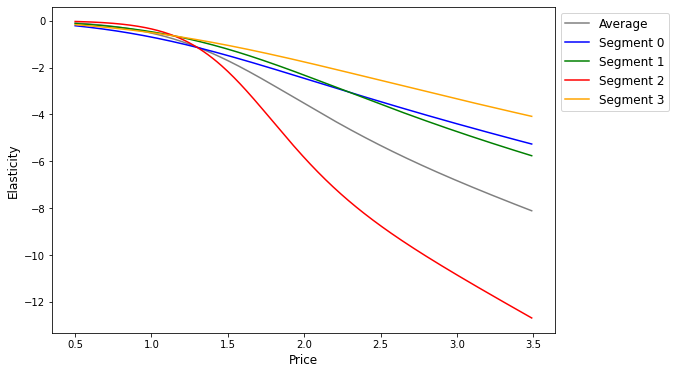

In [27]:
# Display all elasticities of purchase probability on the same plot
plt.figure(figsize = (9, 6))
plt.plot(price_range, price_elasticity, color = "grey")
plt.plot(price_range, pe_segm_0, color = "b")
plt.plot(price_range, pe_segm_1, color = "green")
plt.plot(price_range, pe_segm_2, color = "r")
plt.plot(price_range, pe_segm_3, color = "orange")
plt.xlabel("Price", fontsize = 12)
plt.ylabel("Elasticity", fontsize = 12)
plt.legend(["Average", "Segment 0", "Segment 1", "Segment 2", "Segment 3"],
           loc = "upper left",
           fontsize = 12,
           bbox_to_anchor = (1, 1))

## **Promotion**

### **Data**

In [28]:
# Set the dependent variable to predict the purchase probability
Y = df_pca["Incidence"]

In [29]:
# The dependent variable is based on the the mean across the five prices
X = pd.DataFrame()
X["Mean_Price"] = (df_pca["Price_1"] +
                   df_pca["Price_2"] +
                   df_pca["Price_3"] +
                   df_pca["Price_4"] +
                   df_pca["Price_5"]) / 5

In [30]:
# Include and calculate the average promotion rate across the five brands
X["Mean_Promotion"] = (df_pca["Promotion_1"] +
                       df_pca["Promotion_2"] +
                       df_pca["Promotion_3"] +
                       df_pca["Promotion_4"] +
                       df_pca["Promotion_5"] ) / 5
X.head()

,Mean_Price,Mean_Promotion
0,2.044,0.2
1,2.028,0.0
2,2.028,0.0
3,2.028,0.0
4,2.030,0.0


### **Model**

In [31]:
# Estimate the relationship between promotion and purchase probability
model_promotion = LogisticRegression(solver = "sag")
model_promotion.fit(X, Y)
model_promotion.coef_

array([[-1.49399406,  0.56148226]])

### **Elasticity**

In [32]:
# Create a new data frame and include the price range as the price feature
df_promotion = pd.DataFrame(price_range)
df_promotion = df_promotion.rename(columns = {0: "Price_Range"})
df_promotion.head()

,Price_Range
0,0.50
1,0.51
2,0.52
3,0.53
4,0.54


In [33]:
# Calculate price elasticities of purchase probability when there is a promotion at each price points
df_promotion["Promotion"] = 1
Y_promotion = model_promotion.predict_proba(df_promotion)
promotion = Y_promotion[:, 1]
pe_promo = (model_promotion.coef_[:, 0] * price_range) * (1 - promotion)

In [34]:
# Update master data to include elasticities of purchase probability with promotion feature
df_elasticities["PE_Promotion"] = pe_promo
df_elasticities.head()

,Price_Point,Price_Elasticity,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,PE_Promotion
0,0.50,-0.096399,-0.212866,-0.119047,-0.030899,-0.168014,-0.125736
1,0.51,-0.100467,-0.219566,-0.123229,-0.032664,-0.172938,-0.129852
2,0.52,-0.104662,-0.226379,-0.127505,-0.034517,-0.177932,-0.134047
3,0.53,-0.108987,-0.233306,-0.131875,-0.036460,-0.182997,-0.138322
4,0.54,-0.113445,-0.240348,-0.136341,-0.038498,-0.188134,-0.142678


### **Non-Promoted Price**

In [35]:
# Create a new data frame and include the price range as the price feature
df_no_promo = pd.DataFrame(price_range)
df_no_promo = df_no_promo.rename(columns = {0: "Price_Range"})

In [36]:
# Examine the price elasticity of purchase probability when there is no promotion
df_no_promo["Promotion"] = 0
Y_no_promo = model_promotion.predict_proba(df_no_promo)
no_promotion = Y_no_promo[: , 1]
pe_no_promo = model_promotion.coef_[:, 0] * price_range * (1- no_promotion)

In [37]:
# Update master data frame to include purchase probability elasticities without promotion
df_elasticities["PE_No_Promotion"] = pe_no_promo
df_elasticities.head()

,Price_Point,Price_Elasticity,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,PE_Promotion,PE_No_Promotion
0,0.50,-0.096399,-0.212866,-0.119047,-0.030899,-0.168014,-0.125736,-0.195643
1,0.51,-0.100467,-0.219566,-0.123229,-0.032664,-0.172938,-0.129852,-0.201764
2,0.52,-0.104662,-0.226379,-0.127505,-0.034517,-0.177932,-0.134047,-0.207988
3,0.53,-0.108987,-0.233306,-0.131875,-0.036460,-0.182997,-0.138322,-0.214315
4,0.54,-0.113445,-0.240348,-0.136341,-0.038498,-0.188134,-0.142678,-0.220746


Text(0, 0.5, 'Elasticity')

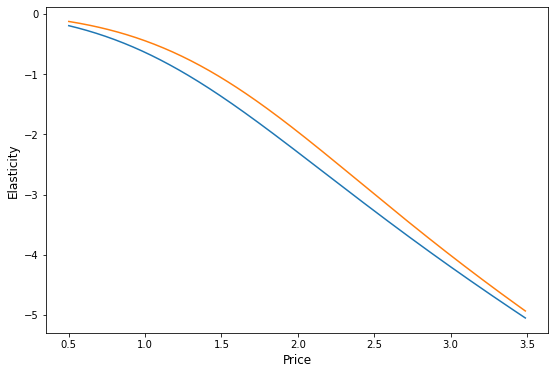

In [38]:
# Plot purchase elasticities with and without promotion side by side for comparison 
plt.figure(figsize = (9, 6))
plt.plot(price_range, pe_no_promo)
plt.plot(price_range, pe_promo)
plt.xlabel("Price", fontsize = 12)
plt.ylabel("Elasticity", fontsize = 12)

## **Brand Choice**

### **Data**

In [39]:
# Filter data to include only purchase occasion when a purchase has occured
brand_choice = df_pca[df_pca["Incidence"] == 1]
pd.options.display.max_rows = 100
brand_choice

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Age,Education,Income,Occupation,Settlement,Segment,Segment_0,Segment_1,Segment_2,Segment_3
6,200000001,28,1,2,2,0,0,1.50,1.90,1.99,...,47,1,110866,1,0,2,0,0,1,0
11,200000001,58,1,5,1,0,0,1.39,1.90,1.91,...,47,1,110866,1,0,2,0,0,1,0
19,200000001,110,1,1,2,0,0,1.47,1.90,1.99,...,47,1,110866,1,0,2,0,0,1,0
24,200000001,142,1,4,1,0,0,1.21,1.35,1.99,...,47,1,110866,1,0,2,0,0,1,0
29,200000001,183,1,2,3,0,0,1.46,1.88,1.97,...,47,1,110866,1,0,2,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58621,200000500,296,1,2,6,0,0,1.48,1.89,2.01,...,42,1,120946,1,0,2,0,0,1,0
58648,200000500,460,1,1,12,0,0,1.35,1.57,2.02,...,42,1,120946,1,0,2,0,0,1,0
58674,200000500,641,1,2,7,0,0,1.50,1.85,2.06,...,42,1,120946,1,0,2,0,0,1,0
58687,200000500,697,1,2,6,0,0,1.42,1.51,1.97,...,42,1,120946,1,0,2,0,0,1,0


In [40]:
# Set the dependent variable to predict the brand choice
Y = brand_choice["Brand"]

In [41]:
# Create the features to predict the dependent variable
features = ["Price_1", "Price_2", "Price_3", "Price_4", "Price_5"]
X = brand_choice[features]

### **Model**

In [42]:
# Estimate the relationship between prices and brand choice
model_brand = LogisticRegression(solver = "sag", multi_class = "multinomial")
model_brand.fit(X, Y)

LogisticRegression(multi_class='multinomial', solver='sag')

In [43]:
# Create a new data frame that contains the coefficients
bc_coefficient = pd.DataFrame(model_brand.coef_)
round(bc_coefficient, 3)

,0,1,2,3,4
0,-3.916,0.658,2.418,0.704,-0.202
1,1.275,-1.880,-0.213,-0.206,0.588
2,1.624,0.562,0.501,1.039,0.453
3,0.575,0.396,-1.401,-1.246,0.249
4,0.443,0.264,-1.305,-0.291,-1.088


In [44]:
# Transpose the data frame to keep with the conventional representation of results
bc_coefficient = pd.DataFrame(np.transpose(model_brand.coef_))

In [45]:
# Add labels for the columns that represent the coefficients of the brands
coefficients = ["Brand_1", "Brand_2", "Brand_3", "Brand_4", "Brand_5"]
bc_coefficient.columns = [coefficients]

In [46]:
# Add labels for the index that represent the coefficients of the prices
prices = ["Price_1", "Price_2", "Price_3", "Price_4", "Price_5"]
bc_coefficient.index = [prices]

In [47]:
# Round and display the coefficients
bc_coefficient = bc_coefficient.round(3)
bc_coefficient

,Brand_1,Brand_2,Brand_3,Brand_4,Brand_5
Price_1,-3.916,1.275,1.624,0.575,0.443
Price_2,0.658,-1.880,0.562,0.396,0.264
Price_3,2.418,-0.213,0.501,-1.401,-1.305
Price_4,0.704,-0.206,1.039,-1.246,-0.291
Price_5,-0.202,0.588,0.453,0.249,-1.088


### **Elasticity**

In [48]:
# Create a new data frame with price columns used to predict the brand choice probabilities
df_brand_5 = pd.DataFrame(index = np.arange(price_range.size))
df_brand_5["Price_1"] = brand_choice["Price_1"].mean()
df_brand_5["Price_2"] = brand_choice["Price_2"].mean()
df_brand_5["Price_3"] = brand_choice["Price_3"].mean()
df_brand_5["Price_4"] = brand_choice["Price_4"].mean()
df_brand_5["Price_5"] = price_range
df_brand_5

,Price_1,Price_2,Price_3,Price_4,Price_5
0,1.384559,1.764717,2.006694,2.159658,0.50
1,1.384559,1.764717,2.006694,2.159658,0.51
2,1.384559,1.764717,2.006694,2.159658,0.52
3,1.384559,1.764717,2.006694,2.159658,0.53
4,1.384559,1.764717,2.006694,2.159658,0.54
...,...,...,...,...,...
295,1.384559,1.764717,2.006694,2.159658,3.45
296,1.384559,1.764717,2.006694,2.159658,3.46
297,1.384559,1.764717,2.006694,2.159658,3.47
298,1.384559,1.764717,2.006694,2.159658,3.48


In [49]:
# Predict brand choice probability for the fifth brand
brand_5 = model_brand.predict_proba(df_brand_5)
pr_brand_5 = brand_5[: ][:, 4]

In [50]:
# The beta coefficient required is that of the fifth brand at its own price
beta5 = bc_coefficient.iloc[4, 4]
beta5

-1.088

In [51]:
# Calculate price elasticities for brand choice without promotion
pe_br_5 = beta5 * price_range * (1 - pr_brand_5)

In [52]:
# Add the price elasticities to our master data frame
df_elasticities["Brand_5"] = pe_br_5
df_elasticities.head()

,Price_Point,Price_Elasticity,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,PE_Promotion,PE_No_Promotion,Brand_5
0,0.50,-0.096399,-0.212866,-0.119047,-0.030899,-0.168014,-0.125736,-0.195643,-0.048965
1,0.51,-0.100467,-0.219566,-0.123229,-0.032664,-0.172938,-0.129852,-0.201764,-0.050523
2,0.52,-0.104662,-0.226379,-0.127505,-0.034517,-0.177932,-0.134047,-0.207988,-0.052110
3,0.53,-0.108987,-0.233306,-0.131875,-0.036460,-0.182997,-0.138322,-0.214315,-0.053728
4,0.54,-0.113445,-0.240348,-0.136341,-0.038498,-0.188134,-0.142678,-0.220746,-0.055375


### **Cross-Price Elasticity**

In [53]:
# Examine the effect of the changes in price of a competitor brand
df_cross = pd.DataFrame(index = np.arange(price_range.size))
df_cross["Price_1"] = brand_choice["Price_1"].mean()
df_cross["Price_2"] = brand_choice["Price_2"].mean()
df_cross["Price_3"] = brand_choice["Price_3"].mean()
df_cross["Price_4"] = price_range
df_cross["Price_5"] = brand_choice["Price_5"].mean()

df_cross.head()

,Price_1,Price_2,Price_3,Price_4,Price_5
0,1.384559,1.764717,2.006694,0.50,2.654296
1,1.384559,1.764717,2.006694,0.51,2.654296
2,1.384559,1.764717,2.006694,0.52,2.654296
3,1.384559,1.764717,2.006694,0.53,2.654296
4,1.384559,1.764717,2.006694,0.54,2.654296


In [54]:
# Predict brand choice probability for the competitor brand
predict_cross = model_brand.predict_proba(df_cross)
predict_cross

array([[0.00996327, 0.16384096, 0.00386842, 0.60919469, 0.21313266],
       [0.01011858, 0.16488683, 0.00394192, 0.60674102, 0.21431166],
       [0.01027603, 0.16593491, 0.00401671, 0.60428098, 0.21549138],
       ...,
       [0.22461266, 0.24724423, 0.236132  , 0.04189253, 0.25011858],
       [0.22568086, 0.24616863, 0.23805202, 0.04127878, 0.24881971],
       [0.22674482, 0.24508762, 0.23997779, 0.04067236, 0.24751741]])

In [55]:
# Select the brand choice probability for the competitor brand
pr_brand_4 = predict_cross[:][:, 3]

In [56]:
# Calculate the cross-price elasticity using the brand choice probability for the competitor brand
cross_elasticity = -beta5 * price_range * pr_brand_4

In [57]:
# Update price elasticities data frame to include the cross-price elasticities
df_elasticities["Cross-Price_Elasticity"] = cross_elasticity
df_elasticities.head()

,Price_Point,Price_Elasticity,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,PE_Promotion,PE_No_Promotion,Brand_5,Cross-Price_Elasticity
0,0.50,-0.096399,-0.212866,-0.119047,-0.030899,-0.168014,-0.125736,-0.195643,-0.048965,0.331402
1,0.51,-0.100467,-0.219566,-0.123229,-0.032664,-0.172938,-0.129852,-0.201764,-0.050523,0.336668
2,0.52,-0.104662,-0.226379,-0.127505,-0.034517,-0.177932,-0.134047,-0.207988,-0.052110,0.341878
3,0.53,-0.108987,-0.233306,-0.131875,-0.036460,-0.182997,-0.138322,-0.214315,-0.053728,0.347030
4,0.54,-0.113445,-0.240348,-0.136341,-0.038498,-0.188134,-0.142678,-0.220746,-0.055375,0.352126


Text(0, 0.5, 'Elasticity')

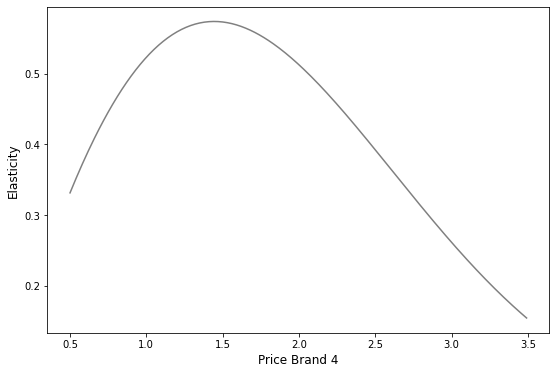

In [58]:
# Examine the cross-price elasticity of brand choice
plt.figure(figsize = (9, 6))
plt.plot(price_range, cross_elasticity, color = "grey")
plt.xlabel("Price Brand 4", fontsize = 12)
plt.ylabel("Elasticity", fontsize = 12)

## **Purchase Quantity**

### **Data**

In [59]:
# Filter the data to contain only visits where the client has purchased at least one product
df_quantity = df_pca[df_pca["Incidence"] == 1]
df_quantity.head()

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Age,Education,Income,Occupation,Settlement,Segment,Segment_0,Segment_1,Segment_2,Segment_3
6,200000001,28,1,2,2,0,0,1.50,1.90,1.99,...,47,1,110866,1,0,2,0,0,1,0
11,200000001,58,1,5,1,0,0,1.39,1.90,1.91,...,47,1,110866,1,0,2,0,0,1,0
19,200000001,110,1,1,2,0,0,1.47,1.90,1.99,...,47,1,110866,1,0,2,0,0,1,0
24,200000001,142,1,4,1,0,0,1.21,1.35,1.99,...,47,1,110866,1,0,2,0,0,1,0
29,200000001,183,1,2,3,0,0,1.46,1.88,1.97,...,47,1,110866,1,0,2,0,0,1,0


In [60]:
# Create brand dummies for each of the five brands
df_quantity = pd.get_dummies(df_quantity, columns = ["Brand"], prefix = "Brand", prefix_sep = "_")
df_quantity.describe()

,ID,Day,Incidence,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,...,Segment,Segment_0,Segment_1,Segment_2,Segment_3,Brand_1,Brand_2,Brand_3,Brand_4,Brand_5
count,1.463800e+04,14638.000000,14638.0,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,...,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000
mean,2.000003e+08,359.607597,1.0,2.774559,1.535251,0.406955,1.384559,1.764717,2.006694,2.159658,...,1.581910,0.175229,0.299290,0.293824,0.231657,0.092226,0.310288,0.057453,0.199959,0.340074
std,1.423786e+02,205.346253,0.0,1.796736,2.060858,0.491283,0.090944,0.181667,0.046200,0.093253,...,1.028171,0.380176,0.457962,0.455528,0.421906,0.289354,0.462627,0.232714,0.399983,0.473750
min,2.000000e+08,1.000000,1.0,1.000000,0.000000,0.000000,1.100000,1.260000,1.870000,1.760000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000001e+08,175.000000,1.0,2.000000,0.000000,0.000000,1.340000,1.570000,1.970000,2.120000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000003e+08,355.000000,1.0,2.000000,0.000000,0.000000,1.390000,1.880000,2.010000,2.180000,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000004e+08,532.000000,1.0,3.000000,4.000000,1.000000,1.470000,1.890000,2.060000,2.240000,...,2.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,2.000005e+08,727.000000,1.0,15.000000,5.000000,1.000000,1.590000,1.900000,2.140000,2.260000,...,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [61]:
# Create a variable that indicates the price of the product purchased
df_quantity["Price_Incidence"] = (df_quantity["Brand_1"] * df_quantity["Price_1"] +
                                  df_quantity["Brand_2"] * df_quantity["Price_2"] +
                                  df_quantity["Brand_3"] * df_quantity["Price_3"] +
                                  df_quantity["Brand_4"] * df_quantity["Price_4"] +
                                  df_quantity["Brand_5"] * df_quantity["Price_5"])

In [62]:
# Create a variable that indicates whether there was a promotion
df_quantity["Promotion_Incidence"] = (df_quantity["Brand_1"] * df_quantity["Promotion_1"] +
                                      df_quantity["Brand_2"] * df_quantity["Promotion_2"] +
                                      df_quantity["Brand_3"] * df_quantity["Promotion_3"] +
                                      df_quantity["Brand_4"] * df_quantity["Promotion_4"] +
                                      df_quantity["Brand_5"] * df_quantity["Promotion_5"])

### **Model**

In [63]:
# Adds the variables to the features used to predict the dependent variable
X = df_quantity[["Price_Incidence", "Promotion_Incidence"]]
pd.options.display.max_rows = 100
X

,Price_Incidence,Promotion_Incidence
6,1.90,0
11,2.62,1
19,1.47,0
24,2.16,0
29,1.88,0
...,...,...
58621,1.89,0
58648,1.35,1
58674,1.85,1
58687,1.51,0


In [64]:
# Set the dependent variable to predict the quantity purchased
Y = df_quantity["Quantity"]
Y.head()

6     2
11    1
19    2
24    1
29    3
Name: Quantity, dtype: int64

In [65]:
# Fit the linear regression model
model_quantity = LinearRegression()
model_quantity.fit(X, Y)
model_quantity.coef_

array([-0.8173651 , -0.10504673])

### **Elasticity**

In [66]:
# Create a new data frame to examine the price elasticity of demand with active promotional activities
df_elasticity = pd.DataFrame(index = np.arange(price_range.size))
df_elasticity["Price_Incidence"] = price_range
df_elasticity["Promotion_Incidence"] = 1

In [67]:
# Compute the coefficient for the price
beta_quantity = model_quantity.coef_[0]
round(beta_quantity, 3)

-0.817

In [68]:
# Predict the quantity of products purchased with promotion
predict_quantity = model_quantity.predict(df_elasticity)

In [69]:
# Calculate the price elasticity of demand with promotion
pe_promo = beta_quantity * price_range / predict_quantity

In [70]:
# Update master data to include elasticities of demand with promotion feature
df_elasticities["PE_Quantity_Promotion"] = pe_promo
df_elasticities.head()

,Price_Point,Price_Elasticity,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,PE_Promotion,PE_No_Promotion,Brand_5,Cross-Price_Elasticity,PE_Quantity_Promotion
0,0.50,-0.096399,-0.212866,-0.119047,-0.030899,-0.168014,-0.125736,-0.195643,-0.048965,0.331402,-0.102157
1,0.51,-0.100467,-0.219566,-0.123229,-0.032664,-0.172938,-0.129852,-0.201764,-0.050523,0.336668,-0.104413
2,0.52,-0.104662,-0.226379,-0.127505,-0.034517,-0.177932,-0.134047,-0.207988,-0.052110,0.341878,-0.106679
3,0.53,-0.108987,-0.233306,-0.131875,-0.036460,-0.182997,-0.138322,-0.214315,-0.053728,0.347030,-0.108954
4,0.54,-0.113445,-0.240348,-0.136341,-0.038498,-0.188134,-0.142678,-0.220746,-0.055375,0.352126,-0.111238


### **Non-Promoted Price**

In [71]:
# Overwrite the promotion incidence variable in order to use the same data
df_elasticity["Promotion_Incidence"] = 0

In [72]:
# Predict the quantity of products purchased without promotion
predict_quantity = model_quantity.predict(df_elasticity)

In [73]:
# Calculate the new price elasticities
pe_no_promo = beta_quantity * price_range / predict_quantity

In [74]:
# Update master data to include elasticities of demand without promotion feature
df_elasticities["PE_Quantity_No_Promotion"] = pe_no_promo
df_elasticities.head()

,Price_Point,Price_Elasticity,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,PE_Promotion,PE_No_Promotion,Brand_5,Cross-Price_Elasticity,PE_Quantity_Promotion,PE_Quantity_No_Promotion
0,0.50,-0.096399,-0.212866,-0.119047,-0.030899,-0.168014,-0.125736,-0.195643,-0.048965,0.331402,-0.102157,-0.099543
1,0.51,-0.100467,-0.219566,-0.123229,-0.032664,-0.172938,-0.129852,-0.201764,-0.050523,0.336668,-0.104413,-0.101736
2,0.52,-0.104662,-0.226379,-0.127505,-0.034517,-0.177932,-0.134047,-0.207988,-0.052110,0.341878,-0.106679,-0.103939
3,0.53,-0.108987,-0.233306,-0.131875,-0.036460,-0.182997,-0.138322,-0.214315,-0.053728,0.347030,-0.108954,-0.106150
4,0.54,-0.113445,-0.240348,-0.136341,-0.038498,-0.188134,-0.142678,-0.220746,-0.055375,0.352126,-0.111238,-0.108369


Text(0, 0.5, 'Elasticity')

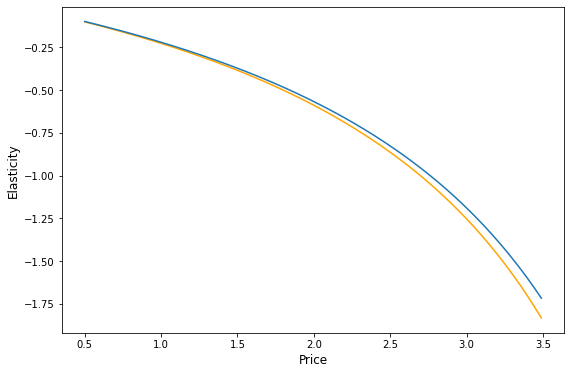

In [75]:
# Plot the elasticities with and without promotion side by side
plt.figure(figsize = (9, 6))
plt.plot(price_range, pe_promo, color = "orange")
plt.plot(price_range, pe_no_promo)
plt.xlabel("Price", fontsize = 12)
plt.ylabel("Elasticity", fontsize = 12)